intrinsic matrix: [[  1.15777829e+03   0.00000000e+00   6.67113866e+02]
 [  0.00000000e+00   1.15282230e+03   3.86124658e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  distortion coeffs: [[-0.24688572 -0.02372824 -0.00109832  0.00035104 -0.00260433]]


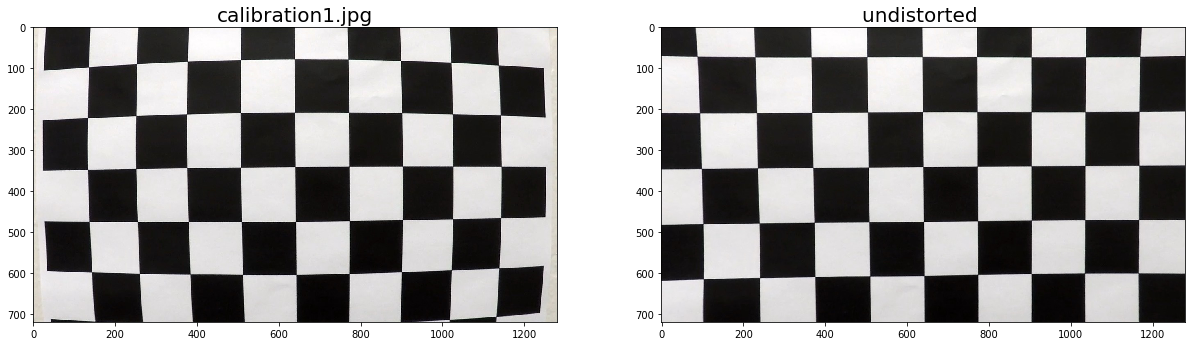

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg

# 1 camera calibration 

nx = 9
ny = 6

## load images and extract chessboard corners 
imgpoints = []
objpoints = []
gray = []
img = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for i in range(1, 21):
    fname = './camera_cal/calibration' + str(i) + '.jpg'
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # find check board corners 
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        # print('corners.shape: {}'.format(corners.shape))
        # img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        # plt.imshow(img)
        # plt.show()
        imgpoints.append(corners)
        objpoints.append(objp)
    # else:
        # print('ret = {} corners: {}'.format(ret, corners))
        # plt.imshow(img)
        # plt.show()
    
# 2. calibration 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# 3. undistort the first image 
img = mpimg.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

# 4. show the result 
# print the calibration result 
print('intrinsic matrix: {}'.format(mtx), ' distortion coeffs: {}'.format(dist))

# plot with various axes scales
# plt.figure(1)

# two columns, left: raw image, right: undistorted image 
# plt.subplot(121)
# plt.imshow(img)
# plt.show()

# plt.subplot(122)
# plt.imshow(undist)
# plt.show()

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
ax1.set_title('calibration1.jpg', fontsize = 20)
ax1.imshow(img)

ax2.set_title('undistorted ', fontsize = 20)
ax2.imshow(undist)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



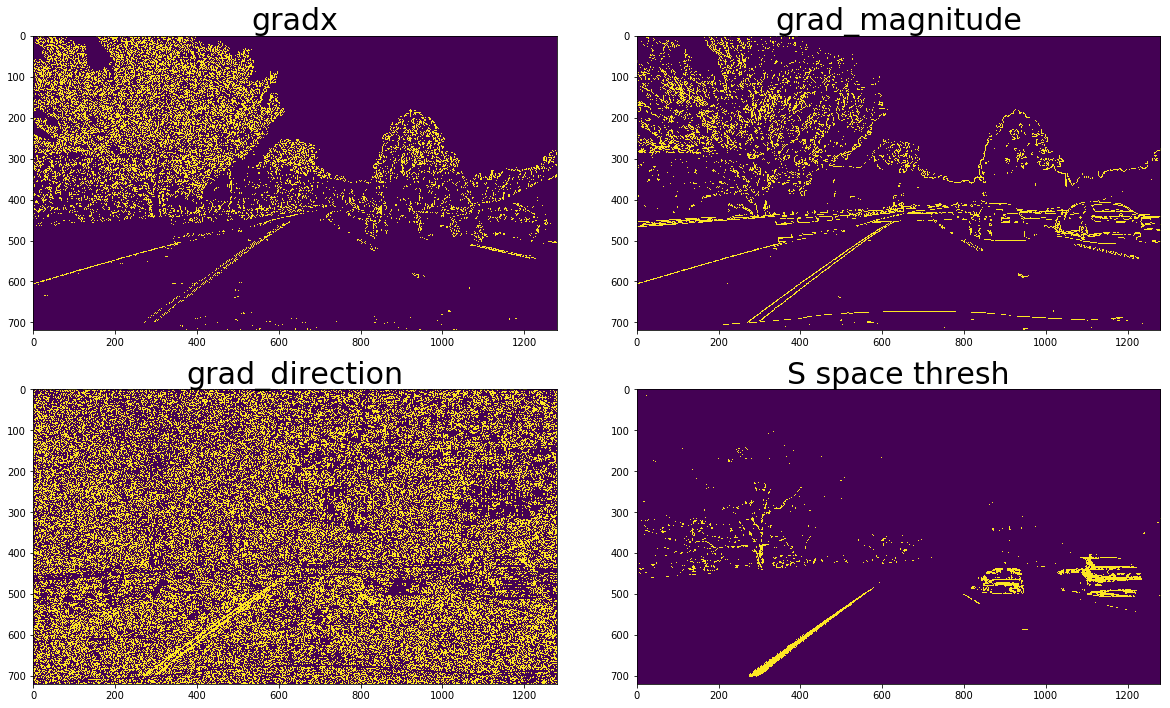

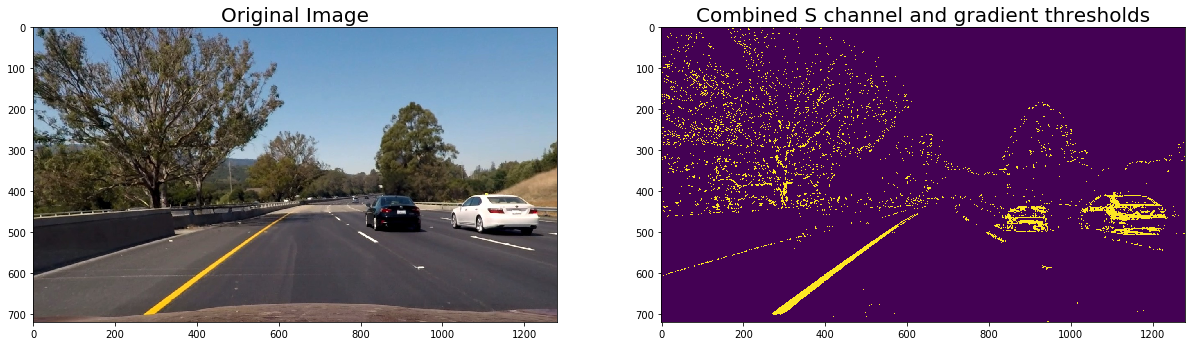

In [79]:
## threshod combination 

def abs_sobel_thresh(img, orient='x', kernel_size= 3, thresh=(0,255)):
    # Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel gradient
    sobel = []
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel_size)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel_size)
    # Sobel absolute 
    sobel_abs = np.absolute(sobel)
    # binary mask using the threshold 
    bin_output = np.zeros_like(sobel_abs)
    bin_output[(sobel_abs >= thresh[0]) & (sobel_abs <= thresh[1])] = 1
    
    return bin_output 

def mag_thresh(img, kernel_size = 3, thresh=(0, 255)):
    # Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel_size)
    # Sobel magnitude 
    sobel_mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # scaled 
    sobel_scale = np.uint8(255 * sobel_mag/np.max(sobel_mag))

    # binary mask using the threshold 
    bin_output = np.zeros_like(sobel_scale)
    bin_output[(sobel_scale >= thresh[0]) & (sobel_scale <= thresh[1])] = 1
    
    return bin_output 

def dir_thresh(img, kernel_size = 3, thresh=(0, 1.)):
    # Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel_size)
    # Sobel orientation 
    sobel_ori = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    # binary mask using the threshold 
    bin_output = np.zeros_like(sobel_ori)
    bin_output[(sobel_ori >= thresh[0]) & (sobel_ori <= thresh[1])] = 1
    
    return bin_output 

def hls_thresh(img, thresh=(0, 255)):
    # Convert to hls space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Saturation 
    s_channel = hls[:,:,2]
    # binary output 
    bin_output = np.zeros_like(s_channel)
    bin_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return bin_output

# Choose a Sobel kernel size 
ksize = 5 # Choose a larger odd number to smooth gradient measurements 

# img = mpimg.imread('test_images/test4.jpg')
img = mpimg.imread('test_images/test6.jpg')
image = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# plt.imshow(image)
# plt.show()

# Apply each of the thresholding functions 
gradx = abs_sobel_thresh(image, orient='x', kernel_size = ksize, thresh=(50, 140))
# grady = abs_sobel_thresh(image, orient='y', kernel_size = ksize, thresh=(0, 255))
mag_bin = mag_thresh(image, ksize, thresh = (50, 150))
dir_bin = dir_thresh(image, 15, thresh = (0.7, 1.3)) # (np.pi/3, np.pi/2))
hls_bin = hls_thresh(image, thresh = (170, 255))

# Plotting output using gradx, grad_magnitude, drad_direction, S_space respectively 
plt.figure(1)
plt.subplots(2,2, figsize = (16, 10))
plt.subplot(221)
plt.title('gradx', fontsize = 30)
plt.imshow(gradx)

plt.subplot(222)
plt.title('grad_magnitude', fontsize = 30)
plt.imshow(mag_bin)

plt.subplot(223)
plt.title('grad_direction', fontsize = 30)
plt.imshow(dir_bin)

plt.subplot(224)
plt.title('S space thresh', fontsize = 30)
plt.imshow(hls_bin)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.0, right=1, hspace=0.2, wspace=0.1)
plt.show()

# ax3.set_title('grad_direction', fontsize = 40)
# ax3.imshow(dir_bin)
# ax4.set_title('S_space thresh', fontsize = 40)
# ax4.imshow(hls_bin)

# combined thresh 
comb_img = np.zeros_like(gray)
comb_img[(hls_bin == 1) | ((mag_bin == 1) & (dir_bin == 1))] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
ax1.set_title('Original Image', fontsize = 20)
ax1.imshow(image)

ax2.set_title('Combined S channel and gradient thresholds', fontsize = 20)
ax2.imshow(comb_img)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



img.shape: (720, 1280, 3)


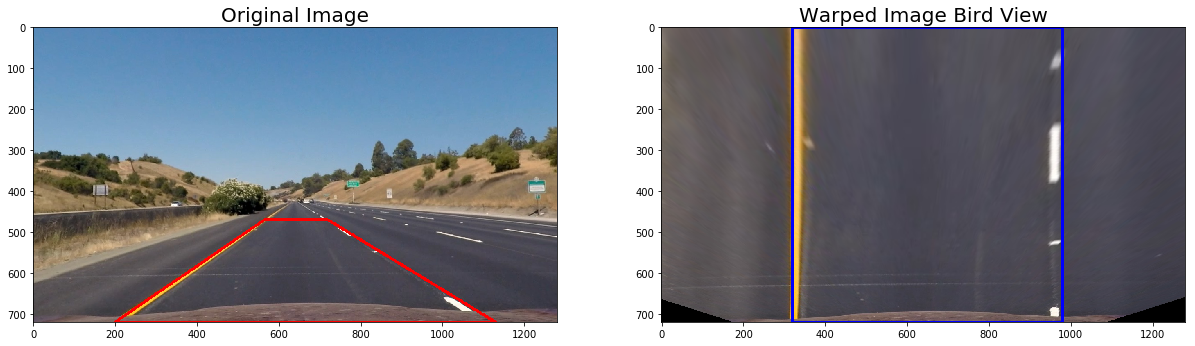

In [91]:
## perspective transform 

image = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(image, mtx, dist, None, mtx)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# associated points 

top_left_src = [565,470]
top_right_src = [720,470]
bottom_right_src = [1130,720]
bottom_left_src = [200,720]

src = np.float32([top_left_src, top_right_src, bottom_right_src, bottom_left_src])

top_left_dst = [320,0]
top_right_dst = [980,0]
bottom_right_dst = [980,720]
bottom_left_dst = [320,720]

dst = np.float32([top_left_dst, top_right_dst, bottom_right_dst, bottom_left_dst])

# warp image 
print('img.shape: {}'.format(img.shape))
img_size = (img.shape[1], img.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

cv2.polylines(img,np.array([src], np.int32),True,(255,0,0), 5)
cv2.polylines(warped,np.array([dst], np.int32) ,True,(0,0,255), 5)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
ax1.set_title('Original Image', fontsize = 20)
ax1.imshow(img)

ax2.set_title('Warped Image Bird View', fontsize = 20)
ax2.imshow(warped)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()




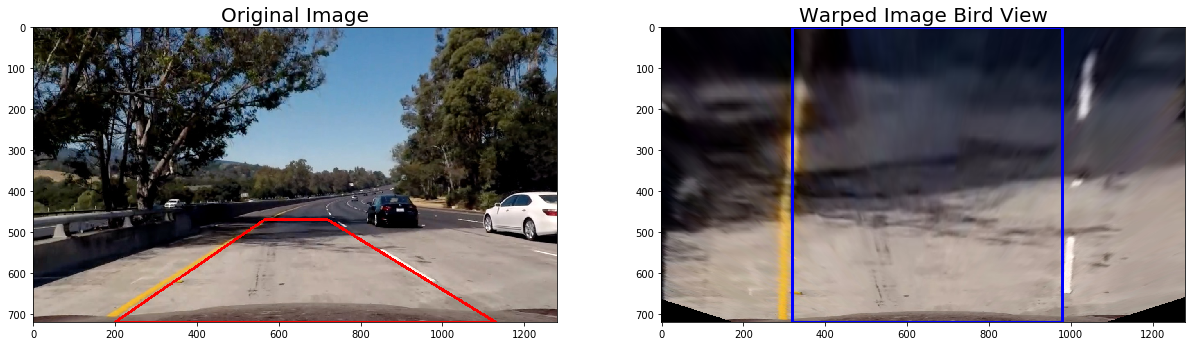

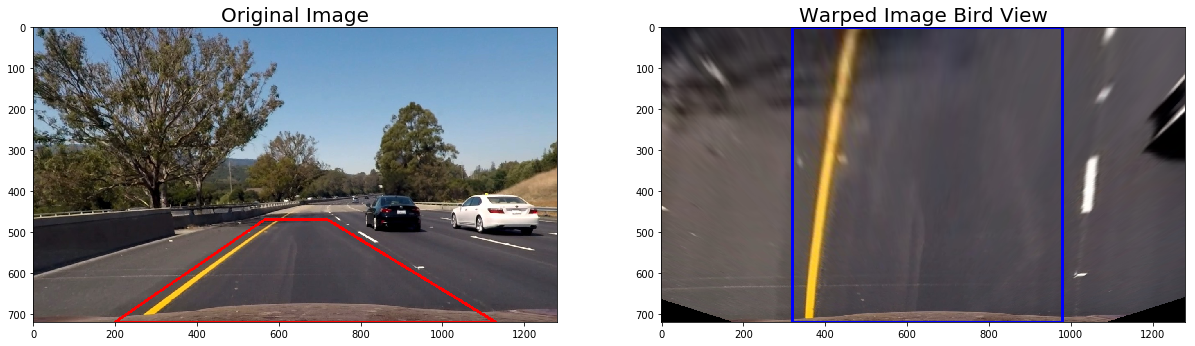

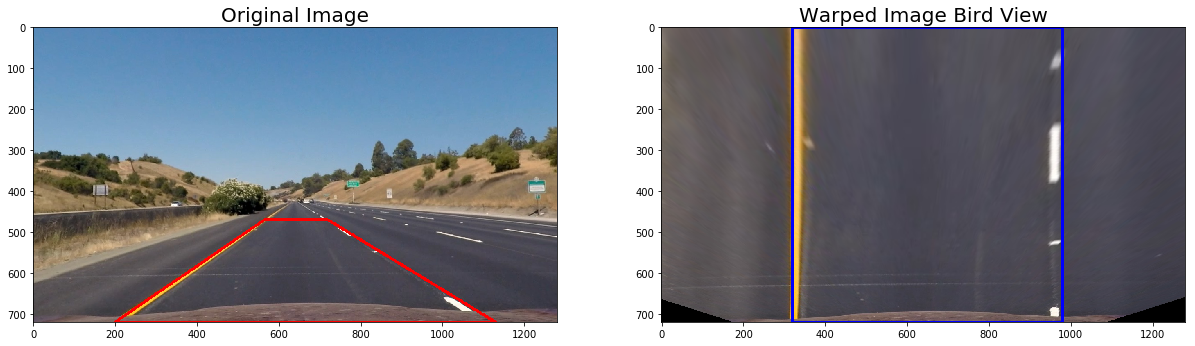

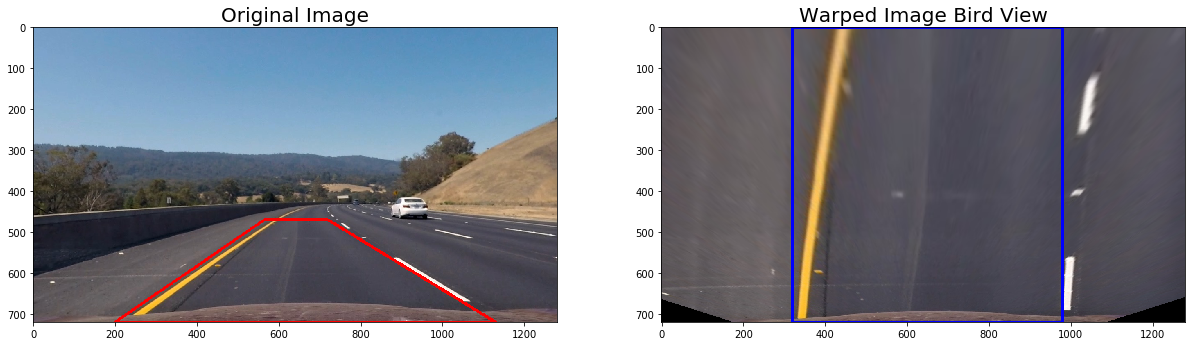

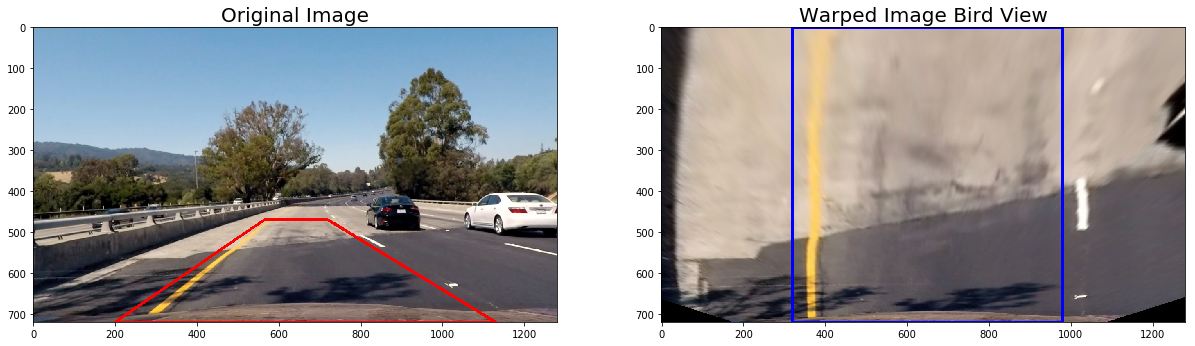

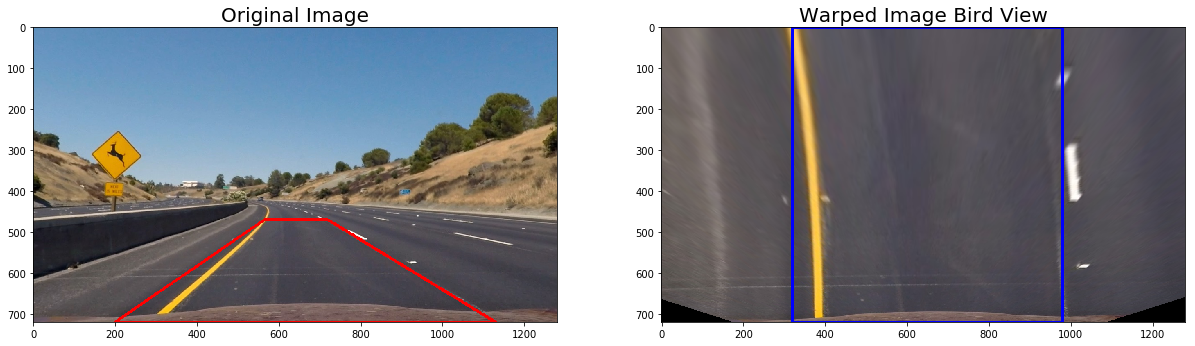

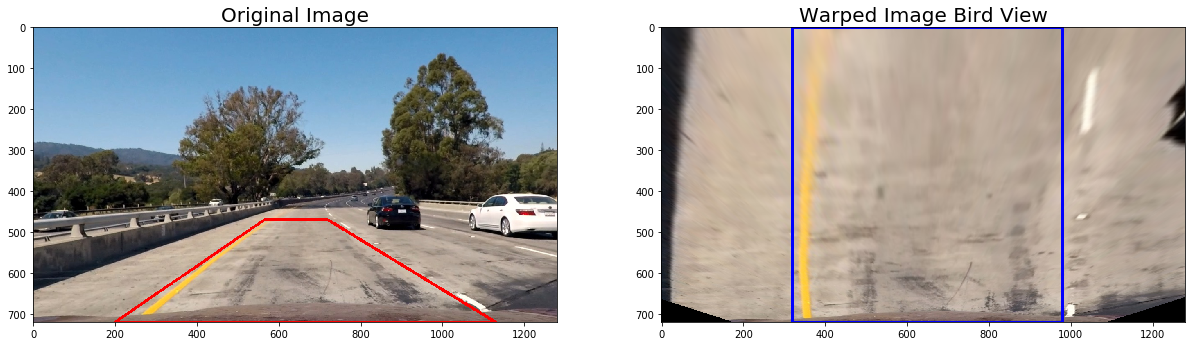

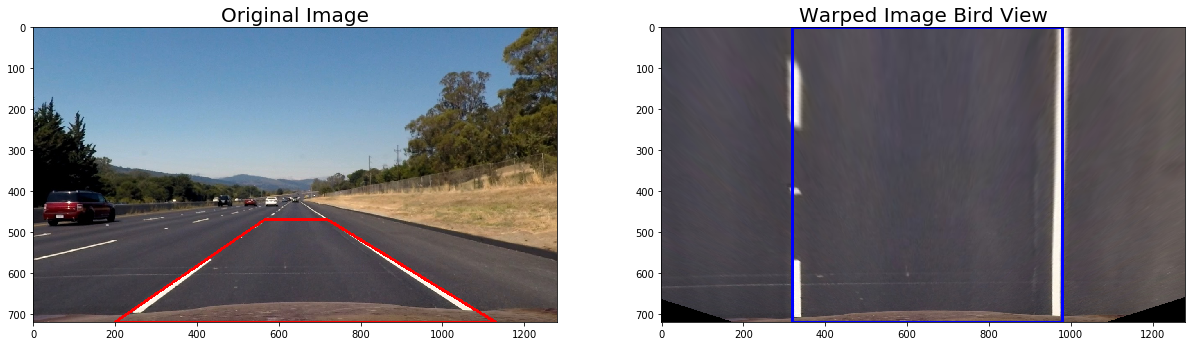

In [92]:
## display the birdview 
import glob 
images = glob.glob('./test_images/*.jpg')

def birdview_transform(image):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    cv2.polylines(img,np.array([src], np.int32),True,(255,0,0), 5)
    cv2.polylines(warped,np.array([dst], np.int32) ,True,(0,0,255), 5)

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
    ax1.set_title('Original Image', fontsize = 20)
    ax1.imshow(img)

    ax2.set_title('Warped Image Bird View', fontsize = 20)
    ax2.imshow(warped)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    return 

for fimage in images:
    image = mpimg.imread(fimage)
    img = cv2.undistort(image, mtx, dist, None, mtx)
    birdview_transform(img)



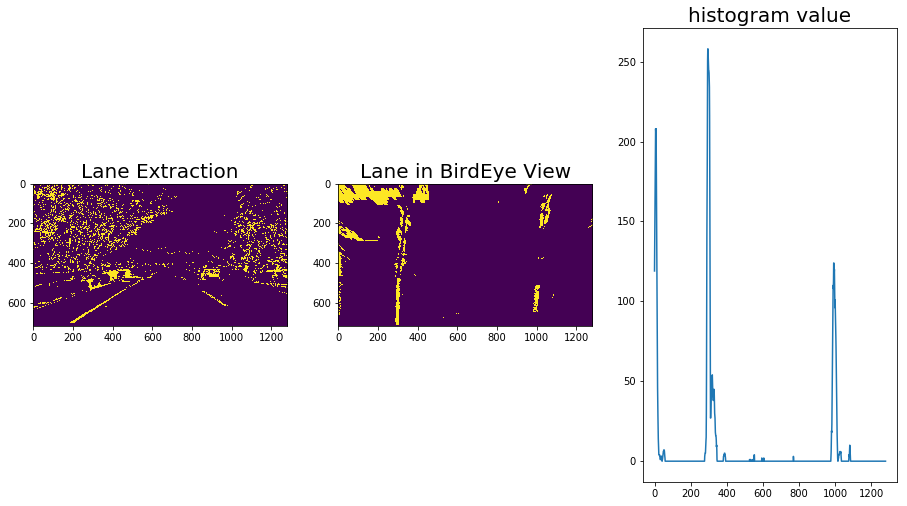

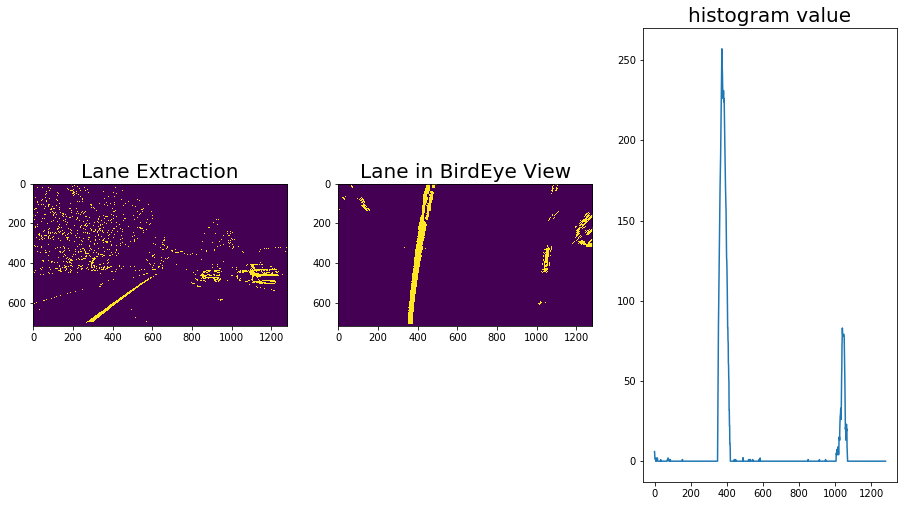

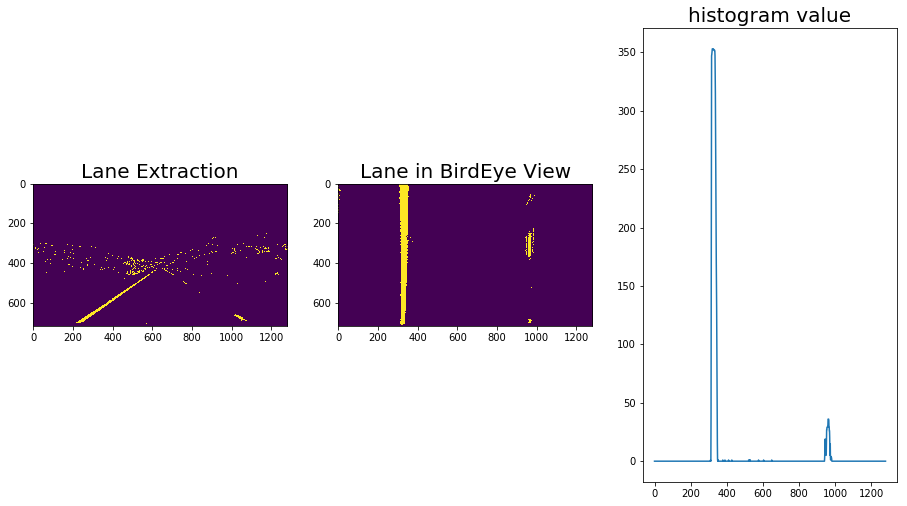

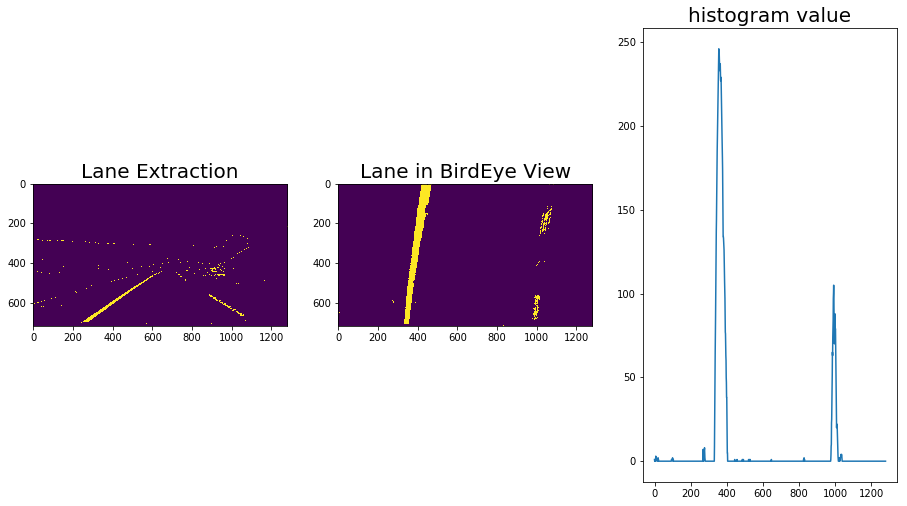

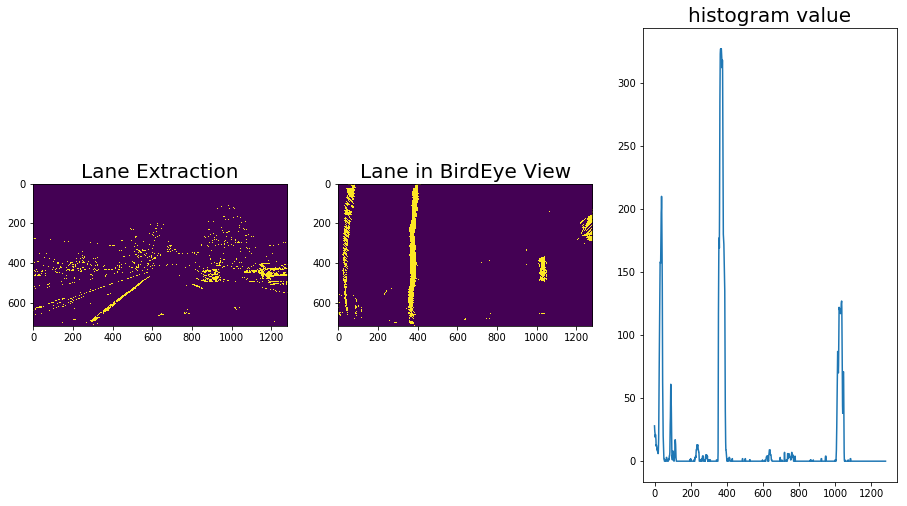

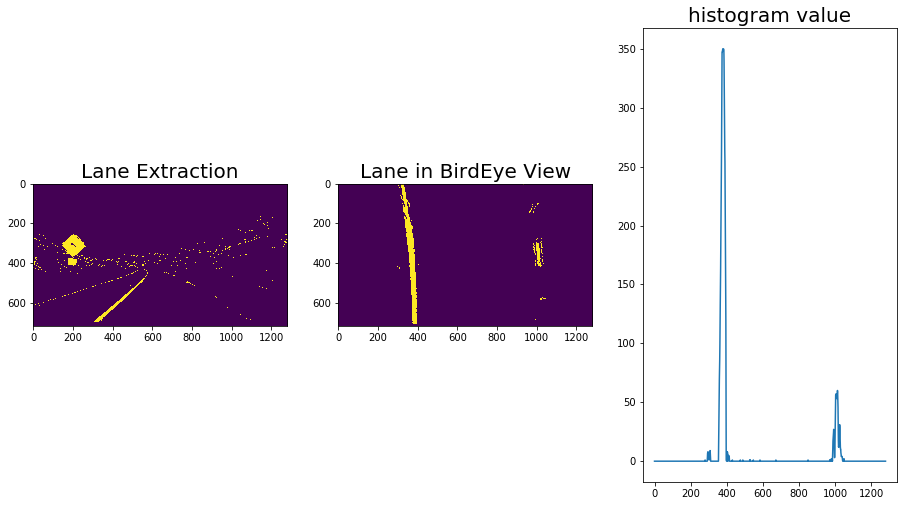

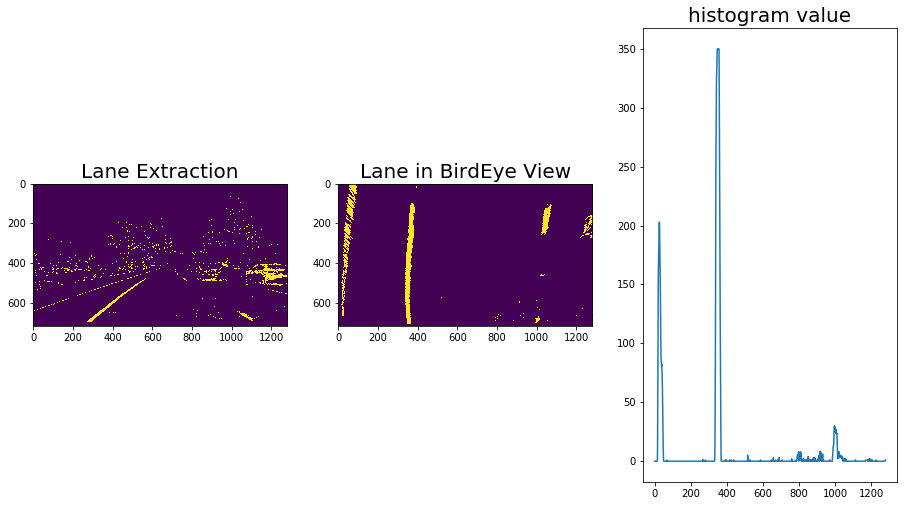

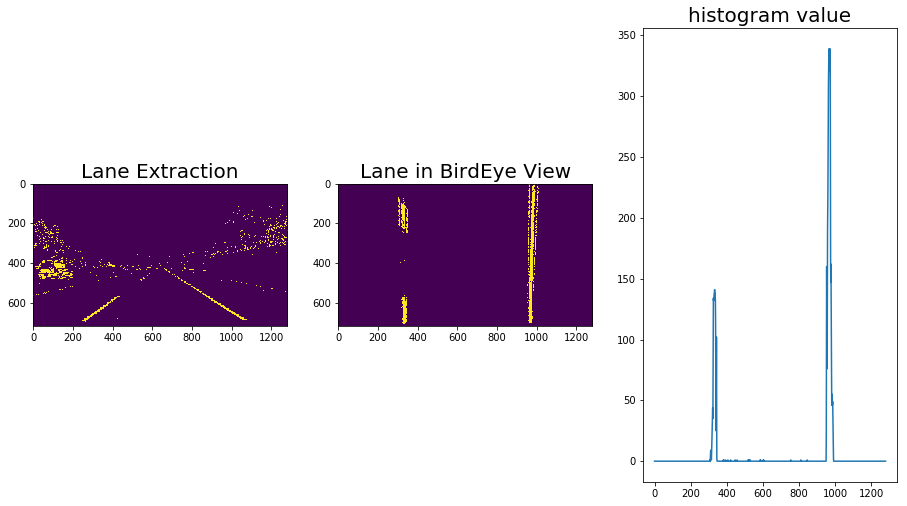

In [95]:
## Detect lane pixels and fit to find the lane boundary.

def comb_thresh(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mag_bin = mag_thresh(image, 5, thresh = (50, 150))
    dir_bin = dir_thresh(image, 15, thresh = (0.7, 1.3)) # (np.pi/3, np.pi/2))
    hls_bin = hls_thresh(image, thresh = (170, 255))
    comb_img = np.zeros_like(gray)
    comb_img[(hls_bin == 1) | ((mag_bin == 1) & (dir_bin == 1))] = 1
    return comb_img

for fimage in images:
    image = mpimg.imread(fimage)
    img = cv2.undistort(image, mtx, dist, None, mtx)
    # extract lanes using combined thresholds 
    comb_img = comb_thresh(img)
    # transform img into birdeye view 
    img_size = (comb_img.shape[1], comb_img.shape[0])
    warped = cv2.warpPerspective(comb_img, M, img_size, flags=cv2.INTER_LINEAR)
    # detect lane lines 
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # display results 
    # Plotting thresholded images
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,7))
    ax1.set_title('Lane Extraction', fontsize = 20)
    ax1.imshow(comb_img)

    ax2.set_title('Lane in BirdEye View', fontsize = 20)
    ax2.imshow(warped)
    
    ax3.set_title('histogram value', fontsize = 20)
    ax3.plot(histogram)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    





In [101]:
## Window based lane line detection 
image = mpimg.imread('./test_images/test1.jpg')
img = cv2.undistort(image, mtx, dist, None, mtx)

# extract lanes using combined thresholds 
comb_img = comb_thresh(img)
# transform img into birdeye view 
img_size = (comb_img.shape[1], comb_img.shape[0])
warped = cv2.warpPerspective(comb_img, M, img_size, flags=cv2.INTER_LINEAR)
# detect lane lines 
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# print(' nonzero: {}'.format(nonzero))

 nonzero: (array([  0,   0,   0, ..., 709, 709, 717]), array([ 63,  64,  65, ..., 363, 364, 646]))


In [114]:
# print('nonzero.len : {}'.format(len(nonzero)))
# print('nonzeroy shape: {}'.format(nonzeroy.shape))
# print('nonzerox shape: {}'.format(nonzerox.shape))

# inds = (nonzeroy >= 500) & (nonzerox <= 500) & (nonzerox >= 200) 
# print('inds {}'.format(inds))
# print('inds.nonzero() : {}'.format(inds.nonzero()))
# print('inds.nonzero()[0] : {}'.format(inds.nonzero()[0]))

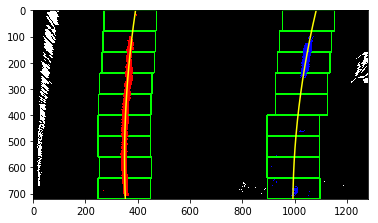

In [147]:
## Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


In [116]:
## compute curvature and estimate distance to the lane lines 

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)



3852.13525255 3192.70842311


In [117]:
## convert to real world space, 
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit a second order polynomial to each
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


1262.35681783 m 1048.47515814 m


In [119]:
## offset 
lane_midpoint = (leftx_base + rightx_base)/2
# midpoint = np.int(histogram.shape[0]/2)
offset = midpoint - lane_midpoint 
if offset < 0: # left
    print('Vehicle is {} m left to the center'.format(-offset*xm_per_pix))
else:
    print('Vehicle is {} m right to the center'.format(offset*xm_per_pix))


Vehicle is 0.16914285714285715 m left to the center


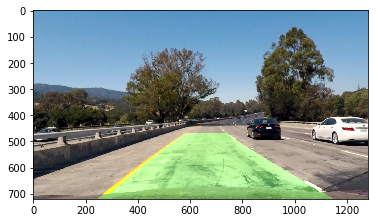

In [129]:
## test 
## wrap back to the raw image and draw it 
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
# color_warp[(np.int_(ploty), np.int_(left_fitx))] = (255, 0, 0)
# color_warp[(np.int_(ploty), np.int_(right_fitx))] = (0, 255, 255)
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()



In [227]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # margin size
        self.margin = 100
        # left lane fit & right lane fit
        self.left_fit = None
        self.right_fit = None
        # Set minimum number of pixels found to recenter window
        self.minpix = 50
        # Choose the number of sliding windows
        self.nwindows = 9
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # curvature and offset 
        self.offset = 0
        self.cur_radius = 0
        
    def lane_points(self, warped):
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        left_fit = self.left_fit
        right_fit = self.right_fit
        
        # detect lane lines 
        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            
        # compute ceter offset 
        lane_midpoint = (leftx_base + rightx_base)/2
        # midpoint = np.int(histogram.shape[0]/2)
        self.offset = (midpoint - lane_midpoint)*self.xm_per_pix
            
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = self.margin
        
        if self.detected == True:
            maxy = warped.shape[1] - 1
            
            pri_lx = (left_fit[0]*(maxy**2) + left_fit[1]*maxy + left_fit[2])
            pri_rx = (right_fit[0]*(maxy**2) + right_fit[1]*maxy + right_fit[2])
            
            # print('pri_lx: {} lbase: {} pri_rx: {}  rbase{}'.format(pri_lx, leftx_base, pri_rx, rightx_base))
            
            if np.absolute(pri_lx - leftx_base) > margin or np.absolute(pri_rx - rightx_base) > margin:
                self.detected = False
                # print('recalculate lane line')
               
        if self.detected == True: # already detect lane in previous frame
            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
            left_fit[1]*nonzeroy + left_fit[2] + margin))) 
                
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
            right_fit[1]*nonzeroy + right_fit[2] + margin)))  
            
        else: # new to detect lane in current frame
            # Choose the number of sliding windows
            nwindows = self.nwindows
            # Set height of windows
            window_height = np.int(warped.shape[0]/nwindows)

            ## Current positions to be updated for each window
            leftx_current = leftx_base 
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = self.margin
            # Set minimum number of pixels found to recenter window
            minpix = self.minpix

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = warped.shape[0] - (window+1)*window_height
                win_y_high = warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
                                  (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]

                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
                                   (nonzerox >= win_xright_low) &  (nonzerox <= win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            self.detected = True
            
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # print('left pts: {}'.format(len(leftx)), 'right pts: {}'.format(len(rightx)))
        
        return leftx, lefty, rightx, righty
            
    def lane_line_detect(self, undistort, warped):
        # Extract left and right line pixel positions
        leftx, lefty, rightx, righty = self.lane_points(warped)
            
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        self.left_fit = left_fit
        self.right_fit = right_fit
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            
        # Fit a second order polynomial to each
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        # print(left_curverad, 'm', right_curverad, 'm')
        self.cur_radius = (left_curverad + right_curverad)/2.
            
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
        
        # add text to image 
        text_cur = 'Radius of Curvature = ' + str(self.cur_radius)[:5] + ' (m)'
        text_offset = 'Vehicle is '
        if self.offset < 0:
            text_offset += str(-self.offset)[:5] + ' (m) left of center'
        else:
            text_offset += str(self.offset)[:5] + ' (m) right of center'    
     
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result, text_cur, (100,100),font, 2, (255, 255, 255), 2, cv2.LINE_AA) #Draw the text
        cv2.putText(result, text_offset, (100, 170), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
        return result
            
                
        

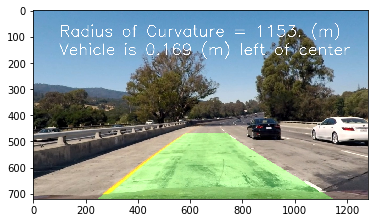

In [228]:
## Window based lane line detection 
image = mpimg.imread('./test_images/test1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
img = comb_thresh(undist)
warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

ll = Line()

out_img = ll.lane_line_detect(undist, warped)
plt.imshow(out_img)
plt.show()

In [231]:
# handle video 
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

laneline = Line()
def process_image(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    comb_img = comb_thresh(undist)
    warped = cv2.warpPerspective(comb_img, M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
       
    # out_img = np.dstack((warped, warped, warped))*255
    out_img = laneline.lane_line_detect(undist, warped)
    
    return out_img


yellow_output = 'output_images/solidYellowLeft.mp4'
# clip2 = VideoFileClip('project_video.mp4').subclip(35, 45)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video output_images/solidYellowLeft.mp4
[MoviePy] Writing video output_images/solidYellowLeft.mp4



 12%|█▏        | 152/1261 [00:33<04:12,  4.38it/s]


 24%|██▍       | 303/1261 [01:07<03:31,  4.53it/s]


 36%|███▌      | 454/1261 [01:40<02:58,  4.52it/s]


 48%|████▊     | 605/1261 [02:14<02:29,  4.40it/s]


 60%|█████▉    | 756/1261 [02:50<01:44,  4.84it/s]


 72%|███████▏  | 907/1261 [03:21<01:18,  4.52it/s]


 84%|████████▍ | 1057/1261 [03:54<00:44,  4.59it/s]


 96%|█████████▌| 1205/1261 [04:26<00:11,  4.70it/s]


100%|█████████▉| 1260/1261 [04:37<00:00,  4.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/solidYellowLeft.mp4 

CPU times: user 8min 54s, sys: 10.5 s, total: 9min 5s
Wall time: 4min 39s


In [232]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>margin = self.margin
""".format(yellow_output))